In [2]:
import jax.numpy as np
from jax import grad, jit, vmap
from jax import random, api
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

from svgd import SVGD, get_bandwidth

from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

cpu


/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [3]:
from jax.scipy.stats import norm

@jit
def logp(x):
    """
    IN: single scalar np array x. alternatively, [x] works too
    OUT: scalar logp(x)
    """
    return np.squeeze(np.sum(norm.logpdf(x, loc=0, scale=1)))

In [4]:
n = 100
d = 1
stepsize = 0.01
L = 300
svgd_adaptive = SVGD(logp, n_iter_max=L, adaptive_kernel=True, get_bandwidth=get_bandwidth, particle_shape=(n, d))

In [4]:
xout, log = svgd_adaptive.unjitted_svgd(svgd_adaptive.rkey, stepsize, bandwidth=0, n_iter=L)
xout.block_until_ready()
print()

In [5]:
st = time.time()
xout, log = svgd_adaptive.svgd(svgd_adaptive.rkey, stepsize, bandwidth=0, n_iter=L)
e1 = time.time()
xout.block_until_ready()
e2 = time.time()
print("until before block:", e1 - st, "s")
print("until after block:", e2 - st, "s")

JIT COMPILING...
Done compiling in 0.21767735481262207 seconds.
until before block: 4.3337061405181885 s
until after block: 5.058032751083374 s


# compare `jit`ted and non`jit`ted times

In [6]:
m = 10

## Using jit

In [7]:
times_j = []

for _ in tqdm(range(m)):
    svgd_adaptive.newkey()
    st = time.time()
    xout, log = svgd_adaptive.svgd(svgd_adaptive.rkey, stepsize, bandwidth=0, n_iter=L)
    xout = xout.block_until_ready()
    end = time.time()
    times_j.append(end - st)
times_j = np.array(times_j)
print("mean time:", np.mean(times_j), "s")
print("stdev:", np.std(times_j), "s")

100%|██████████| 10/10 [00:07<00:00,  1.37it/s]

mean time: 0.71596676 s
stdev: 0.007842689 s


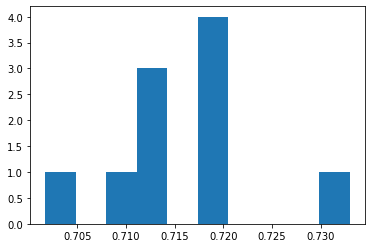

In [8]:
_ = plt.hist(times_j)

## Without jit

In [9]:
times_nojit1 = []
rkey = random.PRNGKey(0)

with api.disable_jit():
    for _ in range(m):
        svgd_adaptive.newkey()
        st = time.time()
        xout, log = svgd_adaptive.svgd(svgd_adaptive.rkey, stepsize, bandwidth=0, n_iter=L)
        xout = xout.block_until_ready()
        end = time.time()
        times_nojit1.append(end - st)
times_nojit1 = np.array(times_nojit1)
print("mean time:", np.mean(times_nojit1), "s")
print("stdev:", np.std(times_nojit1), "s")

JIT COMPILING...
Done compiling in 4.8307976722717285 seconds.
JIT COMPILING...
Done compiling in 4.77505350112915 seconds.
JIT COMPILING...
Done compiling in 5.329846620559692 seconds.
JIT COMPILING...
Done compiling in 5.437087535858154 seconds.
JIT COMPILING...
Done compiling in 4.738233327865601 seconds.
JIT COMPILING...
Done compiling in 4.612656593322754 seconds.
JIT COMPILING...
Done compiling in 4.838158369064331 seconds.
JIT COMPILING...
Done compiling in 4.594719171524048 seconds.
JIT COMPILING...
Done compiling in 4.559055328369141 seconds.
JIT COMPILING...
Done compiling in 4.467915773391724 seconds.
mean time: 5.561055 s
stdev: 0.3392108 s


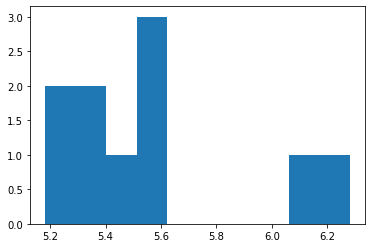

In [10]:
_ = plt.hist(times_nojit1)

In [11]:
times_nojit2 = []
rkey = random.PRNGKey(0)

for _ in tqdm(range(m)):
    svgd_adaptive.newkey()
    st = time.time()
    xout, log = svgd_adaptive.unjitted_svgd(svgd_adaptive.rkey, stepsize, bandwidth=0, n_iter=L)
    xout = xout.block_until_ready()
    end = time.time()
    times_nojit2.append(end - st)
times_nojit2 = np.array(times_nojit2)
print("mean time:", np.mean(times_nojit2), "s")
print("stdev:", np.std(times_nojit2), "s")

100%|██████████| 10/10 [00:57<00:00,  5.73s/it]

mean time: 5.724933 s
stdev: 0.3156142 s


In [12]:
svgd_adaptive.n_iter_max

300

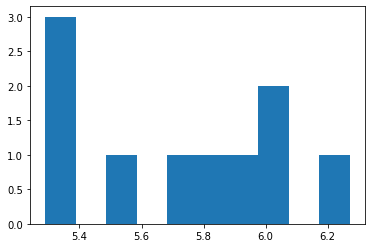

In [13]:
_ = plt.hist(times_nojit2)

## Final comparison

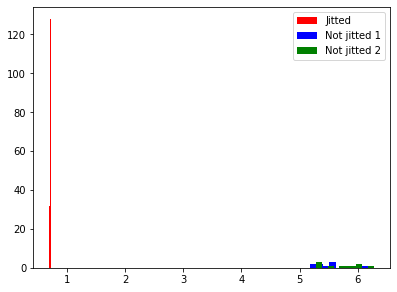

In [14]:
cols = ["r", "b", "g"]
labels = ["Jitted", "Not jitted 1", "Not jitted 2"]

fig = plt.figure(1, figsize=[6.4, 4.8])
for i, times in enumerate([times_j, times_nojit1, times_nojit2]):
    plt.hist(times, color=cols[i], label=labels[i], density=True)
    
_ = plt.legend()

# scaling with $n$

In [62]:
def compile_and_time(n, d, n_iter_max, n_iter):
    svgd_fix = SVGD(logp, n_iter_max=n_iter_max, adaptive_kernel=False, particle_shape=(n,d))
    
    h = 10**2
    stepsize = 0.01
    # run once to compile
    _ = svgd_fix.svgd(svgd_fix.rkey, stepsize, bandwidth=h, n_iter=n_iter)
    
    # run again to time
    st = time.time()
    x, _ = svgd_fix.svgd(svgd_fix.rkey, stepsize, bandwidth=h, n_iter=n_iter)
    x.block_until_ready()
    end = time.time()
    
    return end - st # runtime in seconds

In [69]:
ngrid = np.arange(10, 1200, step=40)
d = 1
n_iter_max = 300
n_iter = n_iter_max
# ntimes = []
for n in ngrid:
    ntimes.append(compile_and_time(n, d, n_iter_max, n_iter))

JIT COMPILING svgd...
...done compiling svgd after 0.08008861541748047 seconds.
JIT COMPILING svgd...
...done compiling svgd after 0.04737377166748047 seconds.
JIT COMPILING svgd...
...done compiling svgd after 0.04400897026062012 seconds.
JIT COMPILING svgd...
...done compiling svgd after 0.044916391372680664 seconds.
JIT COMPILING svgd...
...done compiling svgd after 0.04332327842712402 seconds.
JIT COMPILING svgd...
...done compiling svgd after 0.04346776008605957 seconds.
JIT COMPILING svgd...
...done compiling svgd after 0.043053388595581055 seconds.
JIT COMPILING svgd...
...done compiling svgd after 0.043828725814819336 seconds.
JIT COMPILING svgd...
...done compiling svgd after 0.043778181076049805 seconds.
JIT COMPILING svgd...
...done compiling svgd after 0.07128190994262695 seconds.
JIT COMPILING svgd...
...done compiling svgd after 0.04494833946228027 seconds.
JIT COMPILING svgd...
...done compiling svgd after 0.04241204261779785 seconds.
JIT COMPILING svgd...
...done compil

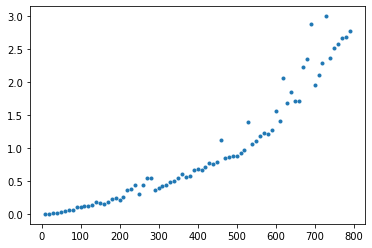

In [88]:
_ = plt.plot(ngrid, ntimes, ".")